In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

#Reading data
data = pd.read_csv('price_data.csv', index_col="Date")
data.head()



Using TensorFlow backend.


,Close,Volume,Market Cap,Oil,Gold,ETH,Ripple,Bitcoin Cash,Litecoin,NEO,Cardano,Stellar,EOS,DASH,NEM,ETH Classic,Lisk
Date,,,,,,,,,,,,,,,,,
"Aug 07, 2015",279.59,42484800,4.032820e+09,47.12,1080.05,2.770000,0.008152,0.008152,4.21,4.21,4.21,0.002432,0.002432,3.26,0.000145,0.000145,1.0
"Aug 08, 2015",261.00,58533000,4.048270e+09,47.12,1080.05,0.753325,0.008476,0.008476,3.85,3.85,3.85,0.002419,0.002419,3.08,0.000136,0.000136,1.0
"Aug 09, 2015",265.08,23789600,3.779770e+09,47.12,1080.05,0.701897,0.008808,0.008808,3.90,3.90,3.90,0.002345,0.002345,3.11,0.000130,0.000130,1.0
"Aug 10, 2015",264.47,20979400,3.843850e+09,44.96,1094.80,0.708448,0.008750,0.008750,3.95,3.95,3.95,0.002466,0.002466,3.08,0.000135,0.000135,1.0
"Aug 11, 2015",270.39,25433900,3.828500e+09,43.08,1113.25,1.070000,0.008591,0.008591,4.16,4.16,4.16,0.002398,0.002398,3.16,0.000135,0.000135,1.0


In [3]:
#Tranform the date field
data.index = pd.to_datetime(data.index)
print(data.index)
data.head(5)

DatetimeIndex(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14',
               '2015-08-15', '2015-08-16',
               ...
               '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22',
               '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26',
               '2018-01-27', '2018-01-28'],
              dtype='datetime64[ns]', name='Date', length=906, freq=None)


,Close,Volume,Market Cap,Oil,Gold,ETH,Ripple,Bitcoin Cash,Litecoin,NEO,Cardano,Stellar,EOS,DASH,NEM,ETH Classic,Lisk
Date,,,,,,,,,,,,,,,,,
2015-08-07,279.59,42484800,4.032820e+09,47.12,1080.05,2.770000,0.008152,0.008152,4.21,4.21,4.21,0.002432,0.002432,3.26,0.000145,0.000145,1.0
2015-08-08,261.00,58533000,4.048270e+09,47.12,1080.05,0.753325,0.008476,0.008476,3.85,3.85,3.85,0.002419,0.002419,3.08,0.000136,0.000136,1.0
2015-08-09,265.08,23789600,3.779770e+09,47.12,1080.05,0.701897,0.008808,0.008808,3.90,3.90,3.90,0.002345,0.002345,3.11,0.000130,0.000130,1.0
2015-08-10,264.47,20979400,3.843850e+09,44.96,1094.80,0.708448,0.008750,0.008750,3.95,3.95,3.95,0.002466,0.002466,3.08,0.000135,0.000135,1.0
2015-08-11,270.39,25433900,3.828500e+09,43.08,1113.25,1.070000,0.008591,0.008591,4.16,4.16,4.16,0.002398,0.002398,3.16,0.000135,0.000135,1.0


Text(0,0.5,'Daily Bitcoin price')

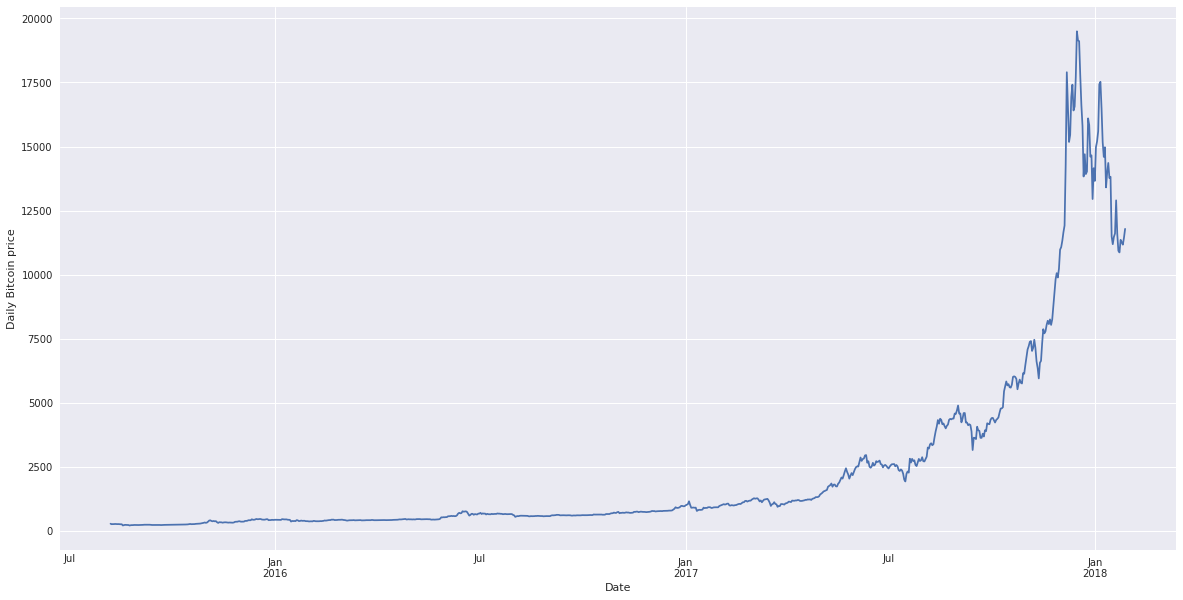

In [4]:

#Plotting the closed price
data['Close'].plot(figsize=(20,10))
plt.ylabel("Daily Bitcoin price")

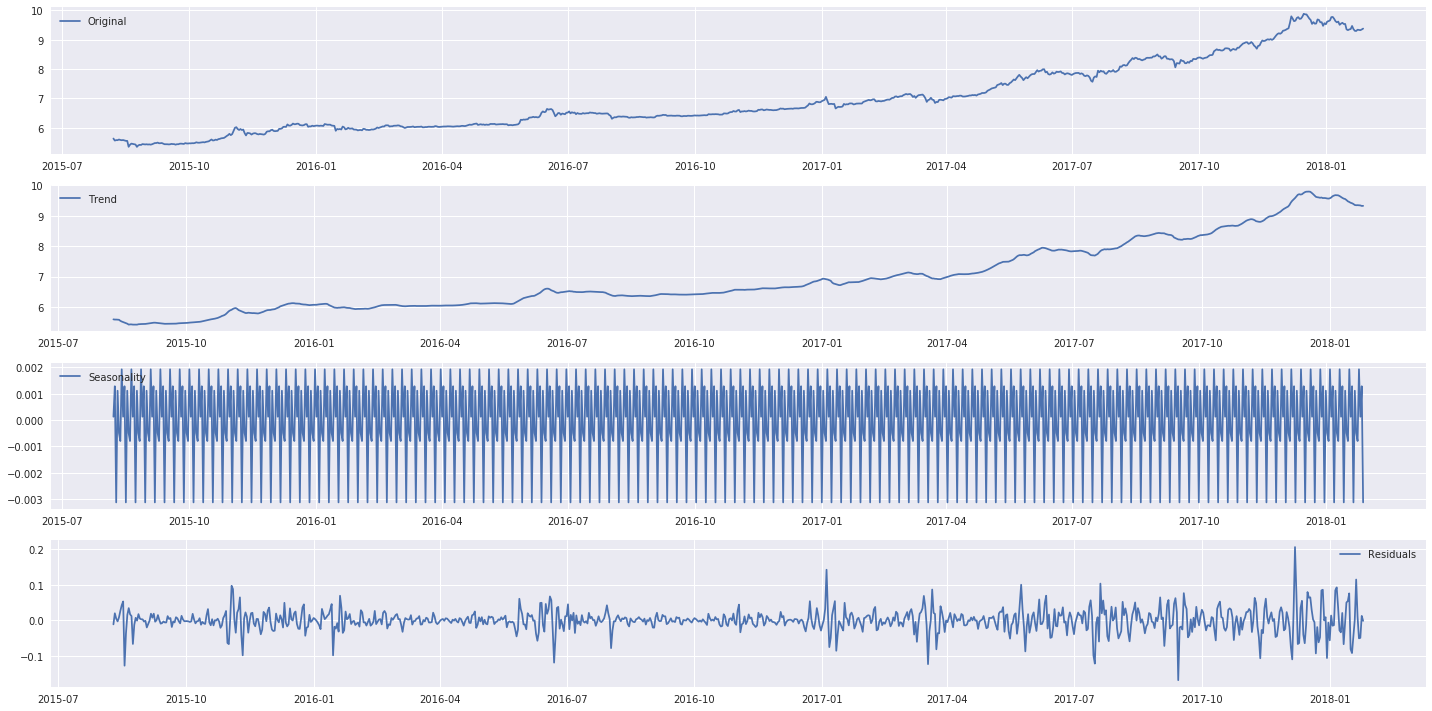

In [5]:
#Checking for seasonality
data1 = data['Close']  #Creating a dataframe with just the closed price 

#Plotting the trends (weekly, monthly, quaterly, yearly)
by_quarter = data1.groupby(data1.index.quarter)
by_quarter.plot(figsize=(20,10))

#Transform the data
ts_logtransformed = np.log(data1)
plt.plot(ts_logtransformed)

#Decomposing
decomposition = seasonal_decompose(ts_logtransformed)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_logtransformed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
import statsmodels.tsa.stattools as ts

result = adfuller(ts_logtransformed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.983686
p-value: 0.994091
Critical Values:
	10%: -2.568
	5%: -2.865
	1%: -3.438


In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
				#-----------------------------#
				#Using bitcoin historical data#
				#-----------------------------#

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(878, 1, 3) (878,) (27, 1, 3) (27,)
Train on 878 samples, validate on 27 samples
Epoch 1/50
 - 0s - loss: 0.0623 - val_loss: 0.5149
Epoch 2/50
 - 0s - loss: 0.0696 - val_loss: 0.4767
Epoch 3/50
 - 0s - loss: 0.0676 - val_loss: 0.4508
Epoch 4/50
 - 0s - loss: 0.0621 - val_loss: 0.4235
Epoch 5/50
 - 0s - loss: 0.0568 - val_loss: 0.3912
Epoch 6/50
 - 0s - loss: 0.0520 - val_loss: 0.3538
Epoch 7/50
 - 0s - loss: 0.0474 - val_loss: 0.3115
Epoch 8/50
 - 0s - loss: 0.0430 - val_loss: 0.2657
Epoch 9/50
 - 0s - loss: 0.0384 - val_loss: 0.2169
Epoch 10/50
 - 0s - loss: 0.0333 - val_loss: 0.1640
Epoch 11/50
 - 0s - loss: 0.0277 - val_loss: 0.1087
Epoch 12/50
 - 0s - loss: 0.0222 - val_loss: 0.0648
Epoch 13/50
 - 0s - loss: 0.0176 -

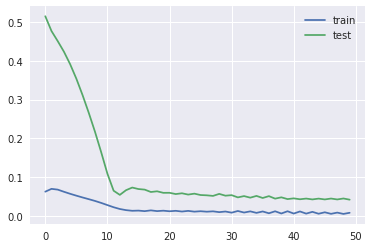

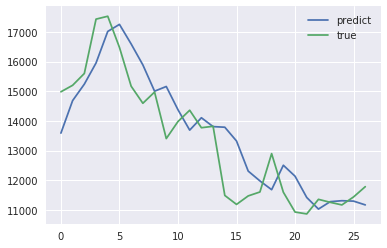

Test RMSE: 1020.892


In [6]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train = 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(634, 1, 3) (634,) (271, 1, 3) (271,)
Train on 634 samples, validate on 271 samples
Epoch 1/50
 - 0s - loss: 0.0083 - val_loss: 0.2804
Epoch 2/50
 - 0s - loss: 0.0170 - val_loss: 0.2704
Epoch 3/50
 - 0s - loss: 0.0161 - val_loss: 0.2764
Epoch 4/50
 - 0s - loss: 0.0133 - val_loss: 0.2760
Epoch 5/50
 - 0s - loss: 0.0119 - val_loss: 0.2679
Epoch 6/50
 - 0s - loss: 0.0110 - val_loss: 0.2568
Epoch 7/50
 - 0s - loss: 0.0105 - val_loss: 0.2449
Epoch 8/50
 - 0s - loss: 0.0107 - val_loss: 0.2363
Epoch 9/50
 - 0s - loss: 0.0107 - val_loss: 0.2291
Epoch 10/50
 - 0s - loss: 0.0101 - val_loss: 0.2194
Epoch 11/50
 - 0s - loss: 0.0097 - val_loss: 0.2096
Epoch 12/50
 - 0s - loss: 0.0096 - val_loss: 0.2006
Epoch 13/50
 - 0s - loss: 0.009

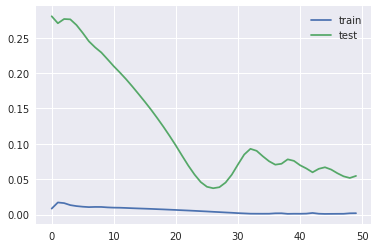

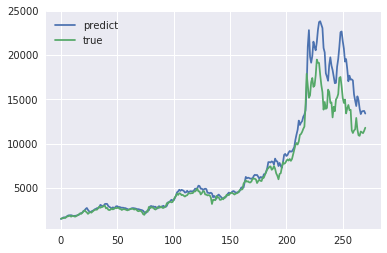

Test RMSE: 1980.355


In [7]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(724, 1, 3) (724,) (181, 1, 3) (181,)
Train on 724 samples, validate on 181 samples
Epoch 1/50
 - 1s - loss: 0.0157 - val_loss: 0.3569
Epoch 2/50
 - 0s - loss: 0.0279 - val_loss: 0.3384
Epoch 3/50
 - 0s - loss: 0.0269 - val_loss: 0.3353
Epoch 4/50
 - 0s - loss: 0.0224 - val_loss: 0.3301
Epoch 5/50
 - 0s - loss: 0.0191 - val_loss: 0.3153
Epoch 6/50
 - 0s - loss: 0.0177 - val_loss: 0.2964
Epoch 7/50
 - 0s - loss: 0.0175 - val_loss: 0.2796
Epoch 8/50
 - 0s - loss: 0.0165 - val_loss: 0.2621
Epoch 9/50
 - 0s - loss: 0.0155 - val_loss: 0.2425
Epoch 10/50
 - 0s - loss: 0.0147 - val_loss: 0.2220
Epoch 11/50
 - 0s - loss: 0.0137 - val_loss: 0.2006
Epoch 12/50
 - 0s - loss: 0.0127 - val_loss: 0.1774
Epoch 13/50
 - 0s - loss: 0.011

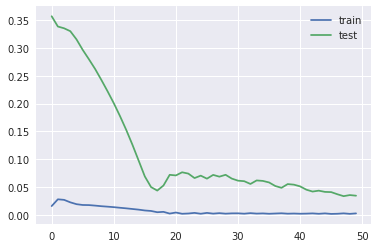

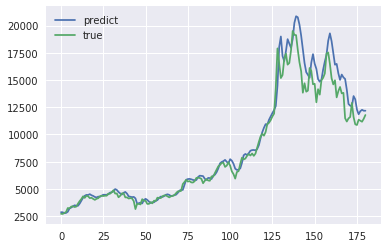

Test RMSE: 1122.050


In [8]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(453, 1, 3) (453,) (452, 1, 3) (452,)
Train on 453 samples, validate on 452 samples
Epoch 1/50
 - 1s - loss: 0.0056 - val_loss: 0.1962
Epoch 2/50
 - 0s - loss: 0.0111 - val_loss: 0.1913
Epoch 3/50
 - 0s - loss: 0.0106 - val_loss: 0.1990
Epoch 4/50
 - 0s - loss: 0.0080 - val_loss: 0.2024
Epoch 5/50
 - 0s - loss: 0.0068 - val_loss: 0.1978
Epoch 6/50
 - 0s - loss: 0.0061 - val_loss: 0.1919
Epoch 7/50
 - 0s - loss: 0.0068 - val_loss: 0.1889
Epoch 8/50
 - 0s - loss: 0.0067 - val_loss: 0.1871
Epoch 9/50
 - 0s - loss: 0.0063 - val_loss: 0.1839
Epoch 10/50
 - 0s - loss: 0.0060 - val_loss: 0.1796
Epoch 11/50
 - 0s - loss: 0.0061 - val_loss: 0.1761
Epoch 12/50
 - 0s - loss: 0.0061 - val_loss: 0.1730
Epoch 13/50
 - 0s - loss: 0.005

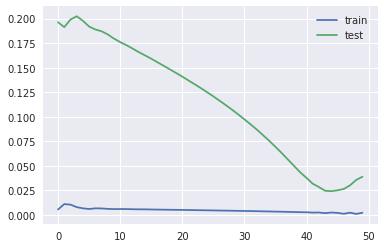

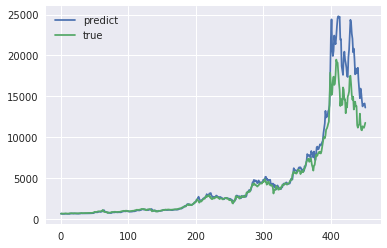

Test RMSE: 1847.875


In [9]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [11]:
                #---------------------#
				#Using additional data#
				#---------------------#

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

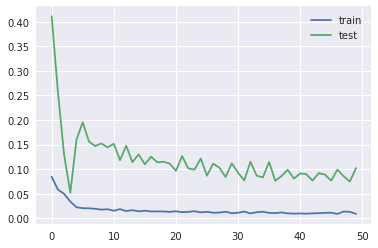

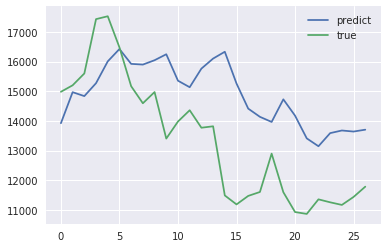

Test RMSE: 2263.412


In [12]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

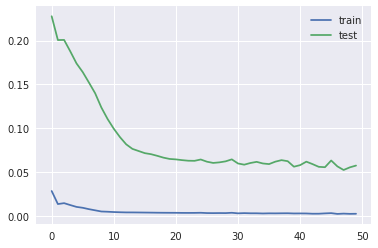

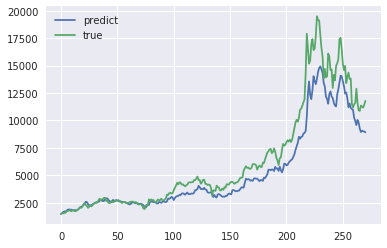

Test RMSE: 1626.957


In [13]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

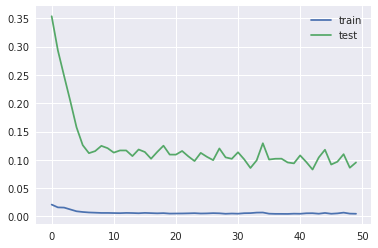

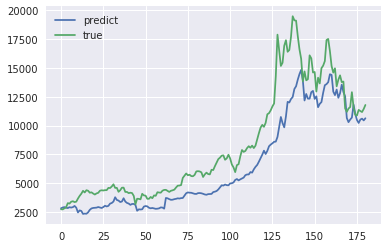

Test RMSE: 2332.766


In [14]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

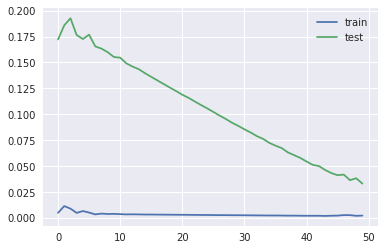

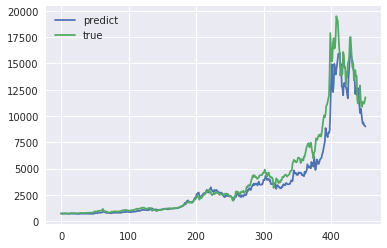

Test RMSE: 1156.968


In [15]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)